In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import mne
import quantities as pq
import neo
#import viziphant
import os
import neo
%matplotlib inline



### Overview:

In developement - using MNE-Python Toolbox, Elephant, and SSIMS/SIMNETS to visualize continuous data


#### WHAT


#### WHY


#### STEPS



#### RESOURCES:


##### MNE-Python Toolbox 
[1] Alexandre Gramfort, Martin Luessi, Eric Larson, Denis A. Engemann, Daniel Strohmeier, Christian Brodbeck, Roman Goj, Mainak Jas, Teon Brooks, Lauri Parkkonen, and Matti S. Hämäläinen. MEG and EEG data analysis with MNE-Python. Frontiers in Neuroscience, 7(267):1–13, 2013. doi:10.3389/fnins.2013.00267.

[2] Elephant (doi:10.5281/zenodo.1186602; RRID:SCR_003833) elephant electrophysiology analysistoolkit: a very useful and well-maintained codebase for analyzing neural data. Includes both classic signal processing tools/tutorials and more advanced neural analysis tools/tutorials. https://elephant.readthedocs.io/en/stable/tutorials/statistics.html www.python-elephant.org

Author: jacqueline_hynes@brown.edu, June 2023
Contact: @author Jacqueline Hynes

#### Load EEG/MEG Data & Extract Trigger/Stim events
We’ll start this tutorial by loading one of the example datasets (called “Sample”), which contains EEG and MEG data from one subject performing an audiovisual experiment, along with structural MRI scans for that subject. 

The mne.datasets.sample.data_path function will automatically download the dataset if it isn’t found in one of the expected locations, then return the directory path to the dataset (see the documentation of data_path for a list of places it checks before downloading). Note: 
- Here, we are using a filtered and downsampled version of the data (sample_audvis_filt-0-40_raw.fif).
- An unfiltered version (sample_audvis_raw.fif) is also included in the sample dataset and could be substituted here when running the tutorial locally



### Explore the Raw Data:

1) plot profile spectral density 
2) plots events ids in time

Opening raw data file /Users/jhynes1/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 41699  =      0.000 ...   277.709 secs...
Effective window size : 13.639 (s)


/Users/jhynes1/anaconda3/envs/mne/lib/python3.11/site-packages/mne/viz/utils.py:151: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


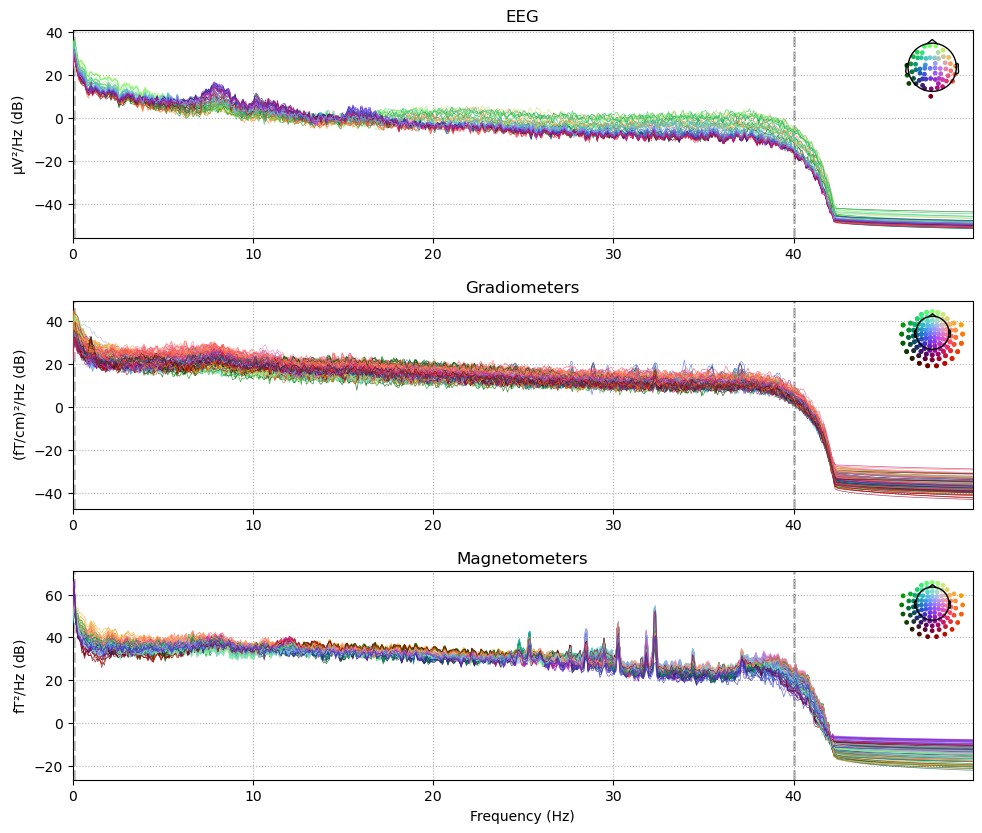

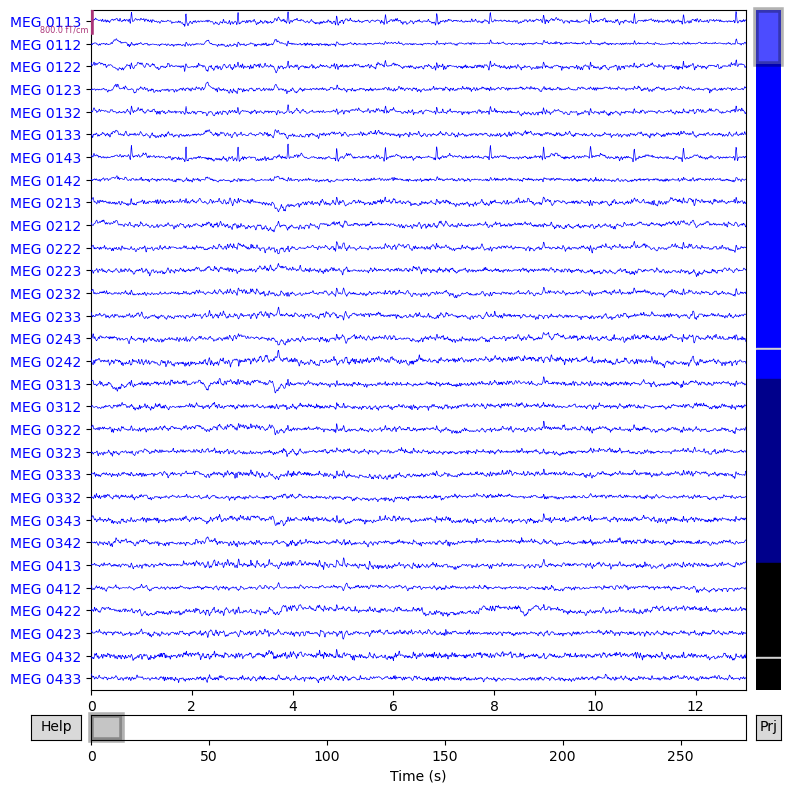

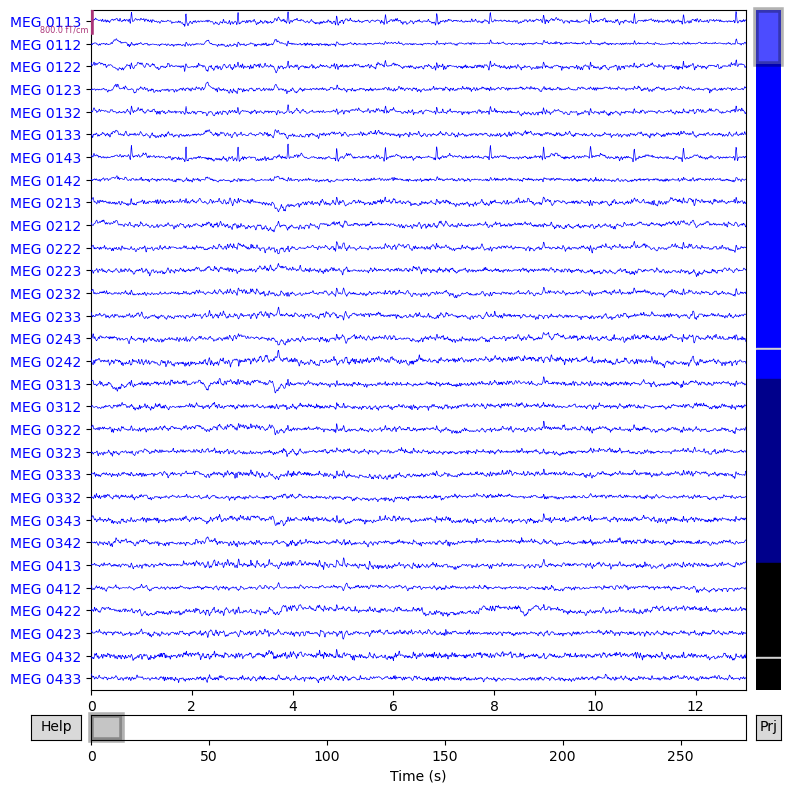

In [56]:
# set path, filename, and use fif read function 
sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = (sample_data_folder / "MEG" / "sample" / "sample_audvis_filt-0-40_raw.fif")

# Extract raw EEG/MEG data
raw = mne.io.read_raw_fif(sample_data_raw_file)
orig_raw = raw.copy()    # this save the loaded data to memory, rather than "read as needed"
raw.load_data()


# Figure 1. visualization of raw data 
raw.compute_psd(fmax=50).plot(picks="data", exclude="bads")
raw.plot(duration=13, n_channels=30 )



### Event Extraction: 
Trigger events are on a specific stim channel:  event dictionary that maps the integer IDs to experimental conditions or events. In this dataset, the mapping looks like this:

Event dictionary: 
    "auditory/left": 1,
    "auditory/right": 2,
    "visual/left": 3,
    "visual/right": 4,
    "smiley": 5,
    "buttonpress": 32,

319 events found
Event IDs: [ 1  2  3  4  5 32]
number of events = (319, 3) 
 first 5 events = [[6994    0    2]
 [7086    0    3]
 [7192    0    1]
 [7304    0    4]
 [7413    0    2]]


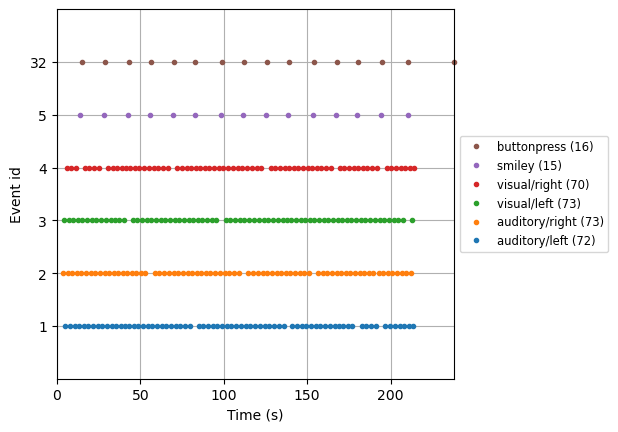

Not setting metadata
319 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 4)
4 projection items activated
Using data from preloaded Raw for 319 events and 106 original time points ...
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 007']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EEG : ['EEG 008']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
10 bad epochs dropped
Dropped 7 epochs: 121, 195, 258, 271, 273, 274, 275


In [57]:

# Extract Events/Triggers 
events = mne.find_events(raw, stim_channel="STI 014")
print(f'number of events = {events.shape} ')
print(f' first 5 events = {events[:5]}')

# event mapping
event_dict = {
    "auditory/left": 1,
    "auditory/right": 2,
    "visual/left": 3,
    "visual/right": 4,
    "smiley": 5,
    "buttonpress": 32,
}

# Figure 1. visualization of tigger events
fig3 = mne.viz.plot_events(events, event_id=event_dict, sfreq=raw.info["sfreq"], first_samp=raw.first_samp)


# Extract Epochs: 
reject_criteria = dict(mag=4000e-15,  # 4000 fT
    grad=4000e-13,  # 4000 fT/cm
    eeg=150e-6,  # 150 µV
    eog=250e-6,
)  # 250 µV

epochs = mne.Epochs(raw,events, event_id=event_dict, tmin=-0.2, tmax=0.5, reject=reject_criteria, preload=True)
conds_we_care_about = ["auditory/left", "auditory/right", "visual/left", "visual/right"]
epochs.equalize_event_counts(conds_we_care_about)  # this operates in-place
aud_epochs = epochs["auditory"]
vis_epochs = epochs["visual"]

epochs_np = np.array(epochs)
aud_epochs_np = np.array(aud_epochs)
vis_epochs_np = np.array(vis_epochs)



Not setting metadata
136 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
136 matching events found
No baseline correction applied
0 projection items activated


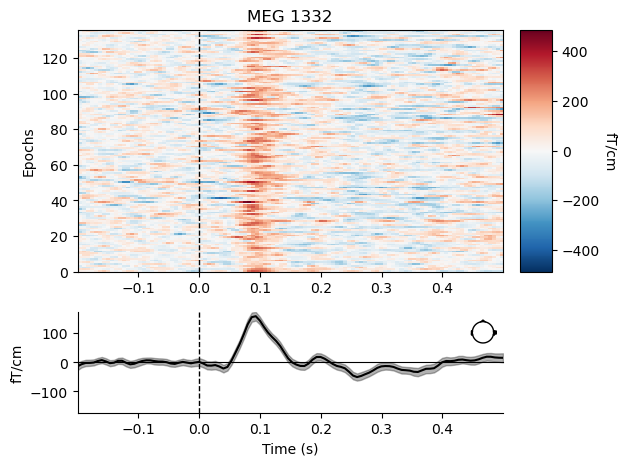

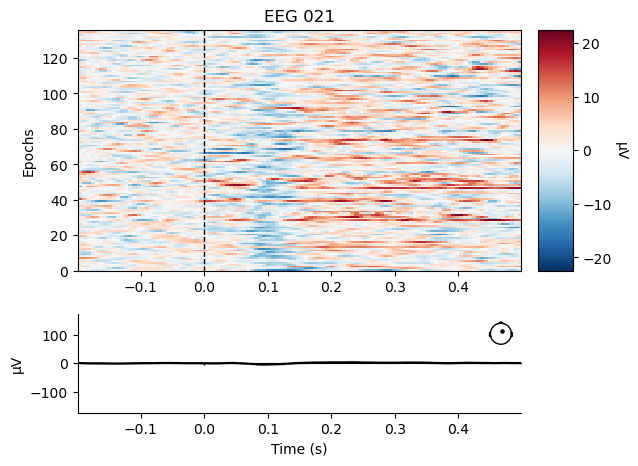

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>
Removing projector <Projection | Average EEG reference, active : True, n_channels : 60>
Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>
Removing projector <Projection | Average EEG reference, active : True, n_channels : 60>
No baseline correction applied


[Parallel(n_jobs=1)]: Done 364 out of 364 | elapsed:    5.1s finished


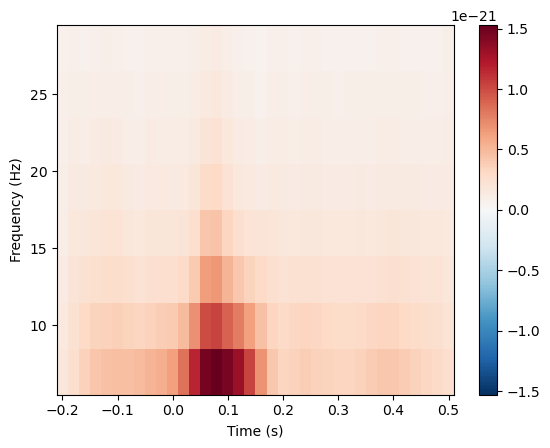

In [58]:
%matplotlib inline

# Plotting
fig4 = aud_epochs.plot_image(picks=["MEG 1332", "EEG 021"])

# Time-frequency analysis 
frequencies = np.arange(7, 30, 3)
power = mne.time_frequency.tfr_morlet(aud_epochs, n_cycles=2, return_itc=False, freqs=frequencies, decim=3)

fig5 = power.plot(["MEG 1332"])



In [59]:
from elephant.spike_train_dissimilarity import van_rossum_distance
tau = 10.0 * pq.ms

print(f' epochs_np(events, time, channels) = {epochs_np.shape}')
print(f' epochs_aud_np(events, time, channels) = {vis_epochs_np.shape}')


print(epochs_np.shape)
ssimdist_pop = []
spkdist_vec = [] 
for n in range(num_neurons):
    
    spkdist_vec = []
    for sx in range(num_trials):
        
        for sy in range(num_trials):    
           vrdist = van_rossum_distance([spks_population[n,sx], spks_population[n,sy]],tau)[0, 1]
           vrdist_vec.append(vrdist)      
    ssimdist_pop.append(spkdist_vec)
       
ssimdist_pop = np.array(ssimdist_pop) 
print(ssimdist_pop.shape)

 epochs_np(events, time, channels) = (302, 376, 106)
 epochs_aud_np(events, time, channels) = (136, 376, 106)
(302, 376, 106)


NameError: name 'num_neurons' is not defined

### Preprocessing:
Let's try a few data pre-processing techniques using: mne.preprocessing and mne.filter submodules. 
- maxwell filtering, 
- signal-space projection, 
- independent components analysis, filtering, 
- downsampling 



Fitting ICA to data using 364 channels (please be patient, this may take a while)
Selecting by number: 19 components
Fitting ICA took 3.5s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated


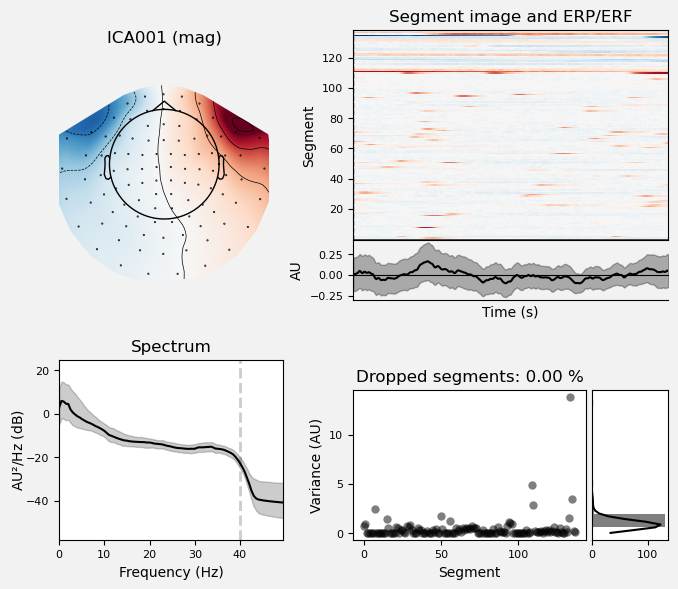

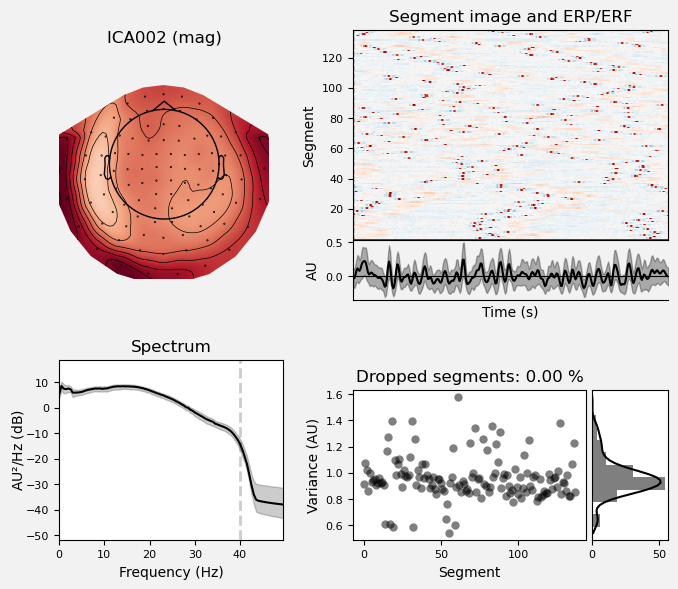

In [10]:

 
# ICA: set up and fit the ICA
ica = mne.preprocessing.ICA(n_components=19, random_state=97, max_iter=800)
ica.fit(raw)
ica.exclude = [1, 2]  # Exclude ICA 1 and 2  details on how we picked these are omitted here
ica.plot_properties(raw, picks=ica.exclude)



# Select Example Channels
chs = [
    "MEG 0111", "MEG 0121",  "MEG 0131", "MEG 0211", "MEG 0221", "MEG 0231",
    "MEG 0311","MEG 0321", "MEG 0331", "MEG 1511",  "MEG 1521",  "MEG 1531",
    "EEG 001", "EEG 002", "EEG 003", "EEG 004",  "EEG 005", "EEG 006",
    "EEG 007","EEG 008"]


In [11]:
print(raw.ch_names)



['MEG 0113', 'MEG 0112', 'MEG 0111', 'MEG 0122', 'MEG 0123', 'MEG 0121', 'MEG 0132', 'MEG 0133', 'MEG 0131', 'MEG 0143', 'MEG 0142', 'MEG 0141', 'MEG 0213', 'MEG 0212', 'MEG 0211', 'MEG 0222', 'MEG 0223', 'MEG 0221', 'MEG 0232', 'MEG 0233', 'MEG 0231', 'MEG 0243', 'MEG 0242', 'MEG 0241', 'MEG 0313', 'MEG 0312', 'MEG 0311', 'MEG 0322', 'MEG 0323', 'MEG 0321', 'MEG 0333', 'MEG 0332', 'MEG 0331', 'MEG 0343', 'MEG 0342', 'MEG 0341', 'MEG 0413', 'MEG 0412', 'MEG 0411', 'MEG 0422', 'MEG 0423', 'MEG 0421', 'MEG 0432', 'MEG 0433', 'MEG 0431', 'MEG 0443', 'MEG 0442', 'MEG 0441', 'MEG 0513', 'MEG 0512', 'MEG 0511', 'MEG 0523', 'MEG 0522', 'MEG 0521', 'MEG 0532', 'MEG 0533', 'MEG 0531', 'MEG 0542', 'MEG 0543', 'MEG 0541', 'MEG 0613', 'MEG 0612', 'MEG 0611', 'MEG 0622', 'MEG 0623', 'MEG 0621', 'MEG 0633', 'MEG 0632', 'MEG 0631', 'MEG 0642', 'MEG 0643', 'MEG 0641', 'MEG 0713', 'MEG 0712', 'MEG 0711', 'MEG 0723', 'MEG 0722', 'MEG 0721', 'MEG 0733', 'MEG 0732', 'MEG 0731', 'MEG 0743', 'MEG 0742', 'ME